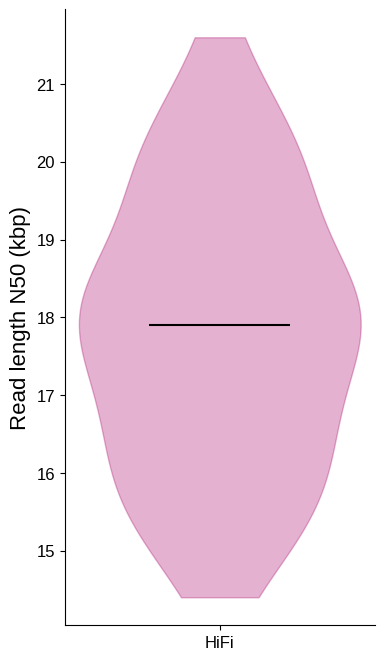

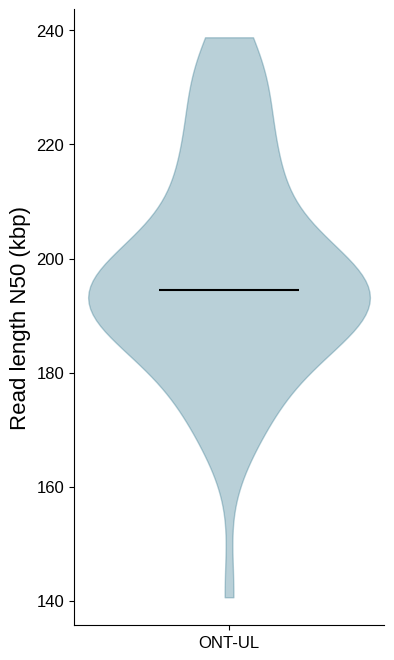

In [4]:
import pathlib
import functools
import matplotlib.pyplot as plt

%cd -q "/home/ebertp/work/code/cubi/project-run-hgsvc-hybrid-assemblies/notebooks"

_PROJECT_CONFIG_NB = str(pathlib.Path("00_project_config.ipynb").resolve(strict=True))
_PLOT_CONFIG_NB = str(pathlib.Path("05_plot_config.ipynb").resolve(strict=True))

%run $_PROJECT_CONFIG_NB
%run $_PLOT_CONFIG_NB

_MYNAME="input-read-summary"
_MYSTAMP=get_nb_stamp(_MYNAME)

_MY_OUT_PATH = PLOT_OUT_MAIN_FIG1.joinpath("panels")


def make_scatter(stat1, label1, stat2, label2):
    """NA24385/HG002 is excluded as data point
    b/c all data are external and its input
    coverage distorts the plot quite a bit.
    """
    
    assert HGSVC_SAMPLES.shape[0] == HGSVC_TOTAL

    sub = HGSVC_SAMPLES.loc[HGSVC_SAMPLES["sample"] != "NA24385", :].copy()
    
    xvals = sub[stat1].values
    yvals = sub[stat2].values
    colors = sub["rgb_rel_super"].values
    colors = [tupleize(color) for color in colors]
    
    fig, ax = plt.subplots(figsize=(8,8))
    
    ax.scatter(
        xvals,
        yvals,
        c=colors,
        marker=GENERIC_MARKER
    )
    
    ax.set_xlabel(label1)
    ax.set_ylabel(label2)
    
    #pop_legend = get_pop_legend()
    #ax.legend(handles=pop_legend, loc="best")
    
    return


def make_violin(stat1, label1, color1, stat2, label2, color2, xlabel, ylabel, axes, add_target=False, isolate=None):
    """NA24385/HG002 is excluded as data point
    b/c all data are external and its input
    coverage distorts the plot quite a bit.
    """
    
    assert HGSVC_SAMPLES.shape[0] == HGSVC_TOTAL

    if isolate is not None:   
        sub = HGSVC_SAMPLES.loc[HGSVC_SAMPLES["sample"] != isolate, :].copy()
        iso_val1 = HGSVC_SAMPLES.loc[HGSVC_SAMPLES["sample"] == isolate, stat1].iloc[0]
        iso_val2 = HGSVC_SAMPLES.loc[HGSVC_SAMPLES["sample"] == isolate, stat2].iloc[0]
    else:
        sub = HGSVC_SAMPLES

    vals_left = sub[stat1].values
    vals_right = sub[stat2].values

    x_pos = [1, 1.75]
    
    components = axes.violinplot(
        [vals_left, vals_right],
        x_pos,
        vert=True,
        showmedians=True,
        showmeans=False,
        showextrema=False,
        widths=[0.5, 0.5]
    )
    bodies1, bodies2 = components["bodies"]
    medians = components["cmedians"]
    medians.set_color("black")

    bodies1.set_facecolor(color1)
    bodies1.set_edgecolor(color1)

    bodies2.set_facecolor(color2)
    bodies2.set_edgecolor(color2)

    if add_target:
        hifi_target = 40
        ontul_target = 30

        axes.axhline(hifi_target, 0, 0.25, ls="dotted", lw=2, color="grey")
        axes.axhline(ontul_target, 0, 0.85, ls="dotted", lw=2, color="grey")

    axes.set_xticks(x_pos)
    axes.set_xticklabels([label1, label2])
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)

    if isolate is not None:
        # manual fix
        if isolate == "NA24385":
            text = f"{isolate} / HG002\n{label1}: ~{iso_val1}\n{label2}: ~{iso_val2}"
        else:
            text = f"{isolate}\n{label1}: ~{iso_val1}\n{label2}: ~{iso_val2}"
        axes.text(
            1.5, 100, text, fontsize=MPL_TEXT_SIZE,
            bbox=MPL_TEXT_BBOX
        )
    
    return axes


def make_single_violin(stat, label, color, xlabel, ylabel, axes):

    assert HGSVC_SAMPLES.shape[0] == HGSVC_TOTAL
    assert stat in HGSVC_SAMPLES.columns
    
    x_pos = [1]
    
    components = axes.violinplot(
        HGSVC_SAMPLES[stat],
        x_pos,
        vert=True,
        showmedians=True,
        showmeans=False,
        showextrema=False,
        widths=[0.5]
    )
    bodies = components["bodies"][0]
    medians = components["cmedians"]
    medians.set_color("black")

    bodies.set_facecolor(color)
    bodies.set_edgecolor(color)

    axes.set_xticks(x_pos)
    axes.set_xticklabels([label])
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    
    return axes


#print(HGSVC_SAMPLES.loc[HGSVC_SAMPLES["hifi_cov"] < 40, ["sample", "supergroup", "hifi_cov"]])
#print(HGSVC_SAMPLES.loc[HGSVC_SAMPLES["ontul_cov"] < 30, ["sample", "supergroup", "hifi_cov", "ont_cov", "ontul_cov"]])   
    
#_ = make_scatter("hifi_cov", "HiFi coverage (X-fold)", "ont_cov", "ONT coverage (X-fold)")
#_ = make_scatter("hifi_cov", "HiFi coverage (X-fold)", "ontul_cov", "ONT-UL coverage (X-fold)")
#_ = make_scatter("hifi_n50", "HiFi read length N50 (kbp)", "ont_n50", "ONT read length N50 (kbp)")


def create_read_cov_figure():

    fig, ax = plt.subplots(figsize=(8,8))

    args = (
        "hifi_cov", "HiFi", PACBIO_COLOR,
        "ontul_cov", "ONT-UL", ONT_COLOR,
        "Long-read technology",
        "Coverage (x-fold)"
    )
    kwargs = {
        "add_target": False,
        "isolate": "NA24385"
    }
    
    #ax = make_violin(ax, "hifi_cov", "HiFi", PACBIO_COLOR, "ontul_cov", "ONT-UL", ONT_COLOR, "Coverage (x-fold)", False, "NA24385")
    ax = make_violin(*args, ax, **kwargs)
    for ext in DEFAULT_PLOT_EXT:
        out_path = _MY_OUT_PATH.joinpath(f"fig1_panel_read-cov.{ext}")
        save_figure(out_path, fig)
    plt.close()

    pre_init = functools.partial(make_violin, *args, **kwargs)
    return pre_init


def create_read_n50_figure(which):

    if which == "hifi":
        args = (
            "hifi_n50", "HiFi", PACBIO_COLOR,
            "", "Read length N50 (kbp)"
        )
    elif which == "ontul":
        args = (
            "ontul_n50", "ONT-UL", ONT_COLOR,
            "", "Read length N50 (kbp)"
        )
    else:
        raise ValueError

    fig, ax = plt.subplots(figsize=(4,8))

    ax = make_single_violin(*args, ax)
    for ext in DEFAULT_PLOT_EXT:
        out_path = _MY_OUT_PATH.joinpath(f"fig1_panel_read-cov.{ext}")
        save_figure(out_path, fig)
    plt.close()

    pre_init = functools.partial(make_single_violin, *args)
    return pre_init
        


get_read_cov_panel = create_read_cov_figure()

get_hifi_n50_panel = create_read_n50_figure("hifi")

get_ontul_n50_panel = create_read_n50_figure("ontul")
